Final Year Project Shan Balendra

This is the first Convolutional Neural Network(CNN). 
The code is made to run locally on an NVIDIA GPU using CUDA.
The dataset input can be changed by modifying the line: "dataset = NetworkTrafficDataset(data_folder='C:\\Users\\ShanB\\Documents\\Final Year Project Files')"
To run this code please extract the entire zip folder and change the directory path below to the path for the folder.

This code was run on a machine running CUDA 12.1, PyTorch 2.3.0, python 3.12. On windows 10.

Import the neccessary modules

In [108]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import torch.cuda

load data -csv file folder

In [109]:
# Directory containing all CSV files
directory_path = 'C:/Users/ShanB/Documents/Final Year Project Files/'

# List all CSV files
files = [os.path.join(directory_path, file) for file in os.listdir(directory_path) if file.endswith('.csv')]

# Load and concatenate all CSV files into a single DataFrame
data = pd.concat([pd.read_csv(file) for file in files], ignore_index=True)


Data Preparation- had a lot of issues sanitising the data as it had a few missing and infinite values, the code below should fix it.

issues faced: we need to preserve first data integrity (anomalies in the data traffic could represent important security events) and we also cannot mislead the model(Using mean or median imputation might create artificial patterns that do not exist in the true data distribution).


In [110]:
#Fixed data format errors-
# Remove leading and trailing whitespaces in column names
data.columns = data.columns.str.strip()

# Handle missing and infinite values
data.replace([np.inf, -np.inf], np.nan, inplace=True)
data.dropna(inplace=True)  # Dropping rows with NaN values from infinite values


Define the CNN Model and the classifier

In [111]:
class CNN(nn.Module):
    def __init__(self, num_classes):
        super(CNN, self).__init__()
        self.layer1 = nn.Sequential(
            nn.Conv1d(1, 16, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2))
        self.layer2 = nn.Sequential(
            nn.Conv1d(16, 32, kernel_size=5, stride=1, padding=2),
            nn.ReLU(),
            nn.MaxPool1d(kernel_size=2))
        self.drop_out = nn.Dropout()
        self.fc1 = nn.Linear(32 * 19, 1000)  # Adjust according to your final flattened size
        self.fc2 = nn.Linear(1000, num_classes)

    def forward(self, x):
        x = self.layer1(x)
        x = self.layer2(x)
        x = x.reshape(x.size(0), -1)  # Flatten the output for the dense layer
        x = self.drop_out(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

add GPU support

In [116]:
# Check if CUDA is available and set device accordingly
# Move model to GPU if CUDA is available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.to(device)

# Move the model and data tensors to the GPU device
model = CNN(num_classes).to(device)
X_train, X_test = X_train.to(device), X_test.to(device)
y_train, y_test = y_train.to(device), y_test.to(device)

Prepare the data by adding categorical labels, separating features and labels, and then standardizing the features to ensure they are on a similar scale. -improves performance

In [117]:
# Encode categorical labels
label_encoder = LabelEncoder()
labels = label_encoder.fit_transform(data['Label'])
num_classes = len(np.unique(labels))  # Determine the number of unique labels

# Prepare feature matrix
X = data.drop('Label', axis=1)
y = labels

# Normalize features to improve model training efficiency
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [118]:
#DEBUGGING
unique_labels = np.unique(labels)
print("Unique labels in the dataset:", unique_labels)


Unique labels in the dataset: [ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14]


Set up the data loaders

In [119]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42)

# Convert the arrays to PyTorch tensors
X_train = torch.tensor(X_train, dtype=torch.float32)
X_test = torch.tensor(X_test, dtype=torch.float32)
y_train = torch.tensor(y_train, dtype=torch.long)
y_test = torch.tensor(y_test, dtype=torch.long)

# Create dataset and DataLoader
train_dataset = TensorDataset(X_train, y_train)
test_dataset = TensorDataset(X_test, y_test)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)

Instantiate the CNN model, loss function, and optimizer

In [120]:
#num_classes = len(np.unique(labels))  # fixes an out of bounds error changed labels array
model = CNN(num_classes).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

Training loop

In [122]:
def train_model(num_epochs, model, loaders):
    train_losses, test_losses = [], []
    for epoch in range(num_epochs):
        model.train()
        running_loss = 0.0
        for inputs, labels in loaders['train']:
            inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the same device as model
            inputs = inputs.unsqueeze(1)  # Add a channel dimension
            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
        else:
            test_loss = 0.0
            accuracy = 0
            with torch.no_grad():
                model.eval()
                for inputs, labels in loaders['test']:
                    inputs, labels = inputs.to(device), labels.to(device)  # Move inputs and labels to the same device as model
                    inputs = inputs.unsqueeze(1)
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)
                    test_loss += loss.item()

                    # Calculate probabilities and accuracy
                    _, top_class = outputs.max(1)
                    equals = top_class == labels
                    accuracy += torch.mean(equals.type(torch.float)).item()

            train_losses.append(running_loss / len(loaders['train']))
            test_losses.append(test_loss / len(loaders['test']))

            print(f"Epoch {epoch + 1}/{num_epochs}.. "
                  f"Train loss: {running_loss / len(loaders['train']):.3f}.. "
                  f"Test loss: {test_loss / len(loaders['test']):.3f}.. "
                  f"Test accuracy: {accuracy / len(loaders['test']):.3f}")


# Train the model
train_model(20, model, {'train': train_loader, 'test': test_loader}) #CHANGE NUMBER OF EPOCHS HERE, current value '5' at 99.4 test accuracy.


Epoch 1/20.. Train loss: 0.056.. Test loss: 0.043.. Test accuracy: 0.984
Epoch 2/20.. Train loss: 0.054.. Test loss: 0.042.. Test accuracy: 0.984
Epoch 3/20.. Train loss: 0.050.. Test loss: 0.039.. Test accuracy: 0.985
Epoch 4/20.. Train loss: 0.049.. Test loss: 0.039.. Test accuracy: 0.986
Epoch 5/20.. Train loss: 0.049.. Test loss: 0.039.. Test accuracy: 0.986
Epoch 6/20.. Train loss: 0.048.. Test loss: 0.041.. Test accuracy: 0.984
Epoch 7/20.. Train loss: 0.048.. Test loss: 0.038.. Test accuracy: 0.985
Epoch 8/20.. Train loss: 0.049.. Test loss: 0.040.. Test accuracy: 0.984
Epoch 9/20.. Train loss: 0.048.. Test loss: 0.036.. Test accuracy: 0.985
Epoch 10/20.. Train loss: 0.048.. Test loss: 0.037.. Test accuracy: 0.986
Epoch 11/20.. Train loss: 0.047.. Test loss: 0.041.. Test accuracy: 0.985
Epoch 12/20.. Train loss: 0.047.. Test loss: 0.038.. Test accuracy: 0.985
Epoch 13/20.. Train loss: 0.046.. Test loss: 0.040.. Test accuracy: 0.984
Epoch 14/20.. Train loss: 0.046.. Test loss: 0.

Plotting the training and validation for loss curves

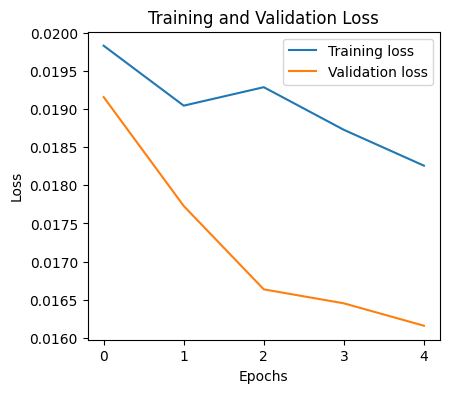

In [123]:
# Plot training and validation loss curves
plt.figure(figsize=(10,4))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()